In [1]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式

from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

import sys
sys.path.append('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron')
from common_function import exp_fitting, plot_curve

h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
def exp_fitting(x,y, num=1):
    
    if num==2:
        # Calculate integrals
        iy1 = cumtrapz(y, x, initial=0)
        iy2 = cumtrapz(iy1, x, initial=0)


        # Get exponentials lambdas
        Y = np.column_stack((iy1, iy2,  x**2, x, np.ones_like(x)))
        A = pinv(Y) @ y

        lambdas = eig(np.array([[A[0], A[1]], [1, 0]]))[0]
        # print("Lambdas:", lambdas)

        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas[0] * x), np.exp(lambdas[1] * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    if num==1:
        iy1 = cumtrapz(y, x, initial=0)

        # Get exponentials lambdas
        Y = np.column_stack((iy1, x, np.ones_like(x)))
        A = pinv(Y) @ y

        lambdas = A[0]
        # print("Lambdas:", lambdas)


        # Get exponentials multipliers
        X = np.column_stack((np.ones_like(x), np.exp(lambdas * x)))
        P = pinv(X) @ y
        # print("Multipliers:", P)
    
    return lambdas, P

def time_constant_fitting(run_dt, dtime, fE, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend', 
                          setIh = False, gIhbar_Ih = 0.):
    
    L5PC = h.L5PCtemplate(morphologyFilename)

    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    if setIh:
        for sec in h.allsec():
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = gIhbar_Ih
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -77.
    v_clamp = -77.


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()

    # attach it to a synapse
    if location == 'dend':
        syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
    if location == 'apic':
        syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -80 for I input
    else: 
        syn.e = -80.
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0e-2  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur2 = h.tstop
    vclamp.amp2 = v_clamp - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        # vol = h.Vector()
    
        # savdata = open("neuron_voltage.dat", "w")
        T = 200./run_dt+1
        N = int(10./dtime)
        data = np.zeros((2*N, int(T)))


        for i in range(1, N+1):
            vclamp.dur1 = 100. + i * dtime

            ncstim.weight[0] = 0e-2
            go()
            # data[4*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

            
            ncstim.weight[0] = fE
            go()
            # data[4*(i-1)+2,:] = recv.to_python()  # Assuming recv is a NEURON Vector
            data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector

        # np.savetxt("neuron_voltage.txt", data)
        # print("Done data!")
        I_w_ng = data[::2, :]
        I_w_g = data[1::2, :]
        diff_I = I_w_ng - I_w_g
        x = np.arange(0.1, 10.1, dtime) # ms
        y = -np.sum(diff_I, axis=1)  # size of 100

        result_lambdas, result_multipliers = exp_fitting(x, y, num=2)
        # ground_truth = np.array([-1., -0.2])
        # relative_error = np.abs((result_lambdas - ground_truth)/ground_truth)
        return result_lambdas, y
    
    
    result_lambdas, y = main()
    return result_lambdas, y
    

/home/wzl/anaconda/envs/neuron9/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO : Using neuron-nightly Package (Developer Version)
/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
cfiles =
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Im.mod" "/home/wzl/LFPy/project/conductance_measurement/real

--No graphics will be displayed.


In [2]:

def rest_potential(run_dt, passive=False, E = True, loc=58,
                          block='',name= '', location ='dend', 
                          setIh = False, gIhbar_Ih = 0.):
    
    L5PC = h.L5PCtemplate(morphologyFilename)

    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    if setIh:
        for sec in h.allsec():
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = gIhbar_Ih
             
    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 1000.
    h.v_init = -77.
    recv = h.Vector()
    recv.record(L5PC.soma[0](0.5)._ref_v)


    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
        # vol = h.Vector()

        go()

        recv0 = recv.to_python()
        plt.plot(recv0)
        # relative_error = np.abs((result_lambdas - ground_truth)/ground_truth)
        return recv0
    
    
    recv0 = main()
    return recv0
    

# resting state : active: -76.4; passive: -90.0

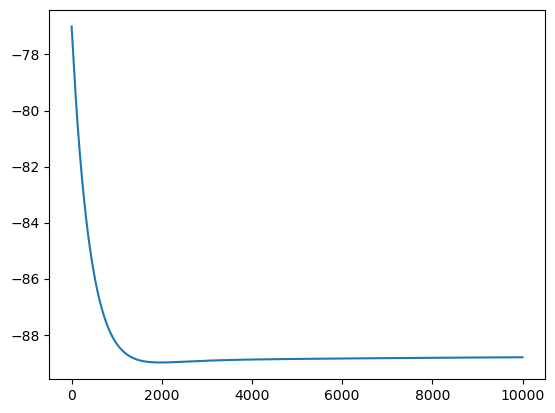

In [16]:
recv = rest_potential(0.1, passive=False, E = True, loc = 58,
                          block='',name= '', location ='dend', 
                          setIh = True, gIhbar_Ih = 0.0002/20)

In [17]:
print(recv[-1])

-88.80457023993146


In [2]:
from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,color='black',title='',linewidth=2, linestyle='-',xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, facecolors='none',
               nonscatter=True, s0=10, facecolor='none'):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=linewidth,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=linewidth,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,edgecolors=color,facecolors = facecolor, alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y, alpha=alpha, label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,fontsize=fontsize,weight='bold')
    ax2.set_ylabel(ylabel,fontsize=fontsize,weight='bold')
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
        # ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=fontsize,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=fontsize,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')

In [3]:
run_dt = 0.1
dtime = 0.1
fE = 1e-3
passive = True
E = True
# loc=58
# location ='dend'
loc=34
location ='apic'
L5PC = h.L5PCtemplate(morphologyFilename)


if passive:
    for sec in h.allsec():
        # 检查 section 是否有主动离子通道
        if h.ismembrane("na3", sec=sec):
            # 将电导设置为0
            sec.gbar_na3 = 0.
        if h.ismembrane("h", sec=sec):
            sec.ghdbar_h = 0.
        if h.ismembrane("kadist", sec=sec):
            sec.gkabar_kadist = 0.
        if h.ismembrane("kaprox", sec=sec):
            sec.gkabar_kaprox = 0.
        if h.ismembrane("kdrca1", sec=sec):
            sec.gkdrbar_kdrca1 = 0.
        if h.ismembrane("nax", sec=sec):
            sec.gbar_nax = 0.
        if h.ismembrane("Ca_HVA",sec=sec):
            sec.gCa_HVAbar_Ca_HVA = 0.
        if h.ismembrane("Ca_LVAst",sec=sec):
            sec.gCa_LVAstbar_Ca_LVAst = 0.
        if h.ismembrane("Ih",sec=sec):
            sec.gIhbar_Ih = 0.
        if h.ismembrane("Im",sec=sec):
            sec.gImbar_Im = 0.
        if h.ismembrane("K_Pst",sec=sec):
            sec.gK_Pstbar_K_Pst = 0.
        if h.ismembrane("K_Tst",sec=sec):
            sec.gK_Tstbar_K_Tst = 0.
        if h.ismembrane("Nap_Et2",sec=sec):
            sec.gNap_Et2bar_Nap_Et2 = 0.
        if h.ismembrane("NaTa_t",sec=sec):
            sec.gNaTa_tbar_NaTa_t = 0.
        if h.ismembrane("NaTs2_t",sec=sec):
            sec.gNaTs2_tbar_NaTs2_t = 0.
        if h.ismembrane("SK_E2",sec=sec):
            sec.gSK_E2bar_SK_E2 = 0.
        if h.ismembrane("SKv3_1",sec=sec):
            sec.gSKv3_1bar_SKv3_1 = 0.   

            
# Set simulation parameters
h.dt = run_dt
h.tstop = 200.
h.v_init = -77.
v_clamp = -77.


# Initialize an excitatory or inhibitory synaptic input
# make a new stimulator
stim = h.NetStim()

# attach it to a synapse
if location == 'dend':
    syn = h.Exp2Syn(L5PC.dend[int(loc)](0.9))
if location == 'apic':
    syn = h.Exp2Syn(L5PC.apic[int(loc)](0.9))
syn.tau1 = 1.  # ms
syn.tau2 = 5.  # ms
if E:
    syn.e = 0.  # mV for E input and -80 for I input
else: 
    syn.e = -80.
# print(syn.e)
    
stim.number = 1
stim.start = 100.  # ms
ncstim = h.NetCon(stim, syn)
ncstim.delay = 0.
ncstim.weight[0] = 0e-2  # uS


# Initialize voltage clamp
vclamp = h.SEClamp(L5PC.soma[0](0.5))
vclamp.amp1 = v_clamp
vclamp.dur2 = h.tstop
vclamp.amp2 = v_clamp - 20.

irec = h.Vector()
irec.record(vclamp._ref_i)

# Function to initialize the simulation
def initialize():
    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

# Function to integrate the simulation
def integrate():
    while h.t < h.tstop:
        h.fadvance()

# Function to run the simulation
def go():
    initialize()
    integrate()



# savdata = open("neuron_voltage.dat", "w")
T = 200./run_dt+1
N = int(20./dtime)
data = np.zeros((2*N, int(T)))


for i in range(1, N+1):
    
    vclamp.dur1 = 100. + i * dtime
    ncstim.weight[0] = 0e-2
    go()
    # data[4*(i-1),:] = recv.to_python()  # Assuming recv is a NEURON Vector
    data[2*(i-1),:] = irec.to_python()  # Assuming irec is a NEURON Vector

    
    ncstim.weight[0] = fE
    go()
    # data[4*(i-1)+2,:] = recv.to_python()  # Assuming recv is a NEURON Vector
    data[2*(i-1)+1,:] = irec.to_python()  # Assuming irec is a NEURON Vector

# np.savetxt("neuron_voltage.txt", data)
# print("Done data!")
I_w_ng = data[::2, :]
I_w_g = data[1::2, :]
diff_I = I_w_ng - I_w_g
x = np.arange(0.1, 20.1, dtime) # ms
y = -np.sum(diff_I, axis=1)  # size of 100

result_lambdas, result_multipliers = exp_fitting(x, y, num=2)

/tmp/ipykernel_1258720/896901297.py:41: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy1 = cumtrapz(y, x, initial=0)
/tmp/ipykernel_1258720/896901297.py:42: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  iy2 = cumtrapz(iy1, x, initial=0)


In [ ]:
result_lambdas, y, diff_I = time_constant_fitting(
            0.1, 0.1, 1e-3, passive = True, E = True, block='', name='')

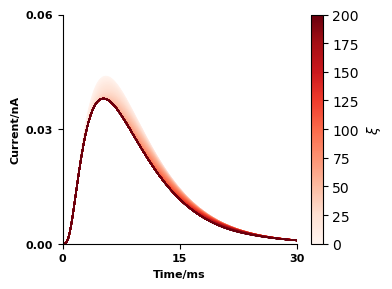

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

A = diff_I
time = np.linspace(0,200,np.shape(A)[1])

# 设置颜色映射
cmap = cm.Reds
norm = mcolors.Normalize(vmin=0, vmax=A.shape[0])

# 创建图形和轴
fig, ax = plt.subplots(1,1, figsize = (4,3))

# 绘制每一行
for i in range(A.shape[0]):
    plot_curve(ax, time[1000:]-time[1000], A[i,1000:], fontsize=8, linewidth=1,
               color=cmap(norm(i)),xlabel='Time/ms', ylabel='Current/nA',xlim=[0,30],
            dx = 15, ylim=[0,0.06], dy =0.03, ynum_decimals=2   )

# 创建颜色条
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # 只是为了满足colorbar方法的要求
plt.colorbar(sm, ax=ax, orientation='vertical', label=r'$\xi$')
plt.tight_layout()

# plt.savefig("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/figure/figrue2/I_syn_xi.eps", format='eps', dpi=300)

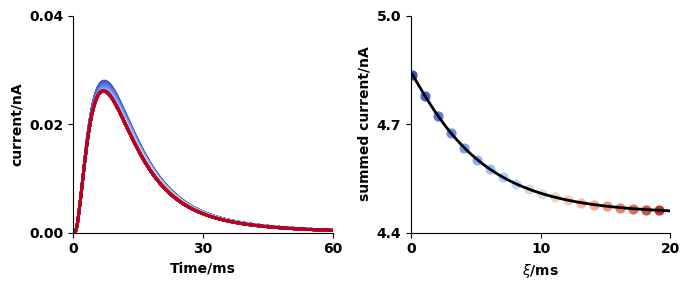

In [10]:
from matplotlib.cm import ScalarMappable
xi =  np.arange(0.1, 20.1, dtime) # ms
time = np.linspace(0,100, 1001)
# 定义一个颜色映射，根据Vclamp值映射颜色
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(xi.min(), xi.max())
sm = ScalarMappable(norm=norm, cmap=cmap)

fig, ax2 = plt.subplots(1,2, figsize = (7,3.))


for i in range(len(xi)):
    color = sm.to_rgba(xi[i])  # 使用Vclamp值对应的颜色
    plot_curve(ax2[0], time, diff_I[i,1000:],color=color,linewidth=2, 
    xlim=[0,60],dx=30, ylim=[0,0.04], dy=0.02, ynum_decimals=2, ylabel='current/nA',)
    if i%10==0:
        plot_curve(ax2[1], xi[i], -y[i], color=color, facecolor=color,
               xlabel=r'$\xi$', xlim=[0,20],dx=10, ylim=[4.,5.5], dy=0., ynum_decimals=1,s0=40, ylabel='summed current/nA',nonscatter=False)
 
# result_lambdas, result_multipliers
x = np.linspace(xi[0],xi[-1],200)
y_con = result_multipliers[0]+result_multipliers[1]*np.exp(result_lambdas[0]*x)+result_multipliers[2]*np.exp(result_lambdas[1]*x)
y_con_truth = result_multipliers[0]+result_multipliers[1]*np.exp(-x)+result_multipliers[2]*np.exp(-0.2*x)


plot_curve(ax2[1],x, -y_con, color='black', xlim=[0,20], dx=10,xlabel=r'$\xi$'+'/ms',
                ylim=[4.4,5.0], dy=0.3, ynum_decimals=1,s0=40, ylabel='summed current/nA')   

# plot_curve(ax2[1],x, -y_con_truth, color='darkred', xlim=[0,20], dx=10,xlabel=r'$\xi$'+'/ms',
#                 ylim=[4.2,5.2], dy=0.5, ynum_decimals=1,s0=40, ylabel='summed current/nA' )   

# 添加colorbar
# cbar = plt.colorbar(sm, ax=ax2[1])
# cbar.set_label(r'$\xi$'+'/ms',fontsize=10,weight='bold')
plt.tight_layout()
plt.savefig('flow_diagram_time_const.eps', format='eps')

In [7]:
min(-y_con), max(-y_con)

(4.46043464383528, 4.836662394147654)

In [11]:
-1./result_lambdas

array([1.07692939, 5.01449964])

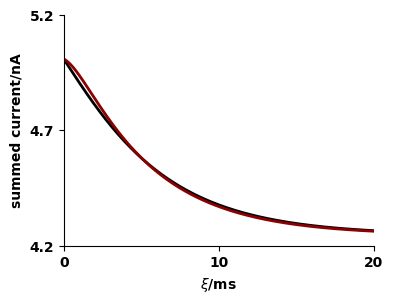

In [15]:
fig, ax2 = plt.subplots(1,1, figsize = (4,3.))
plot_curve(ax2,x, -y_con, color='black', xlim=[0,20], dx=10,xlabel=r'$\xi$'+'/ms',
                ylim=[4.2,5.2], dy=0.5, ynum_decimals=1,s0=40, ylabel='summed current/nA')   

plot_curve(ax2,x, -y_con_truth, color='darkred', xlim=[0,20], dx=10,xlabel=r'$\xi$'+'/ms',
                ylim=[4.2,5.2], dy=0.5, ynum_decimals=1,s0=40, ylabel='summed current/nA' )   
plt.savefig('flow_diagram_time_const_zoomin.eps', format='eps')


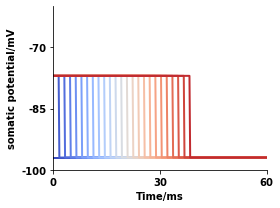

In [66]:
from matplotlib.cm import ScalarMappable
dtime = 0.2
xi =  np.arange(0.1, 40.1, dtime) # ms
time = np.arange(0.1, 60.1, dtime)
# 定义一个颜色映射，根据Vclamp值映射颜色
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(xi.min(), xi.max())
sm = ScalarMappable(norm=norm, cmap=cmap)

fig, ax2 = plt.subplots(1,1, figsize = (4,3.))


for i in range(len(xi)):
    
    if i%8==0:
        V = np.ones_like(time)*-77.
        V[i:]= -77. - 20.
        color = sm.to_rgba(xi[i])  # 使用Vclamp值对应的颜色
        plot_curve(ax2, time, V, color=color, linewidth=2, 
        xlim=[0,60], dx=30, ylim=[-100,-60], dy=15., ynum_decimals=0, ylabel='somatic potential/mV')
    

# cbar = plt.colorbar(sm, ax=ax2[1])
# cbar.set_label(r'$\xi$'+'/ms',fontsize=10,weight='bold')
plt.tight_layout()
plt.savefig('flow_diagram_time_const_somatic_voltage.eps', format='eps')

In [41]:
var = -y
print(np.min(var), np.max(var))

4.247612605272437 4.986744713999087
